In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini")


In [3]:
def multiply(a: int , b: int ) -> int:
    """Multiply a and b
    Args:
        a (int): The first number to multiply
        b (int): The second number to multiply
    Returns:
        int: The product of a and b
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b
    Args:
        a (int): The first number to add
        b (int): The second number to add
    Returns:
        int: The sum of a and b
    """
    return a + b

def divide(a: int, b: int) -> int:
    """Divide a by b
    Args:
        a (int): The number to divide
        b (int): The divisor
    Returns:
        int: The quotient of a and b
    """
    return a / b

tools = [multiply, add, divide]

llm_with_tools = llm.bind_tools(tools)

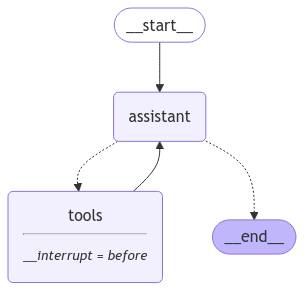

In [9]:
from IPython.display import display, Image
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def assistant(state: MessagesState) -> MessagesState:

    system_message = SystemMessage(content = "You are a helpful assistant that can perform arithemetic operations on a set of inputs.")

    return {"messages" : [llm_with_tools.invoke([system_message] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile(interrupt_before = ["tools"], checkpointer = memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
initial_input = {"messages" : [HumanMessage(content = "What is 2 times 3?")]}

thread = {"configurable" : {"thread_id" : "8"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_POOjexFJlRYPlrT8lmPSocIq)
 Call ID: call_POOjexFJlRYPlrT8lmPSocIq
  Args:
    a: 2
    b: 3


In [26]:
state = graph.get_state(thread)
state.next

('tools',)

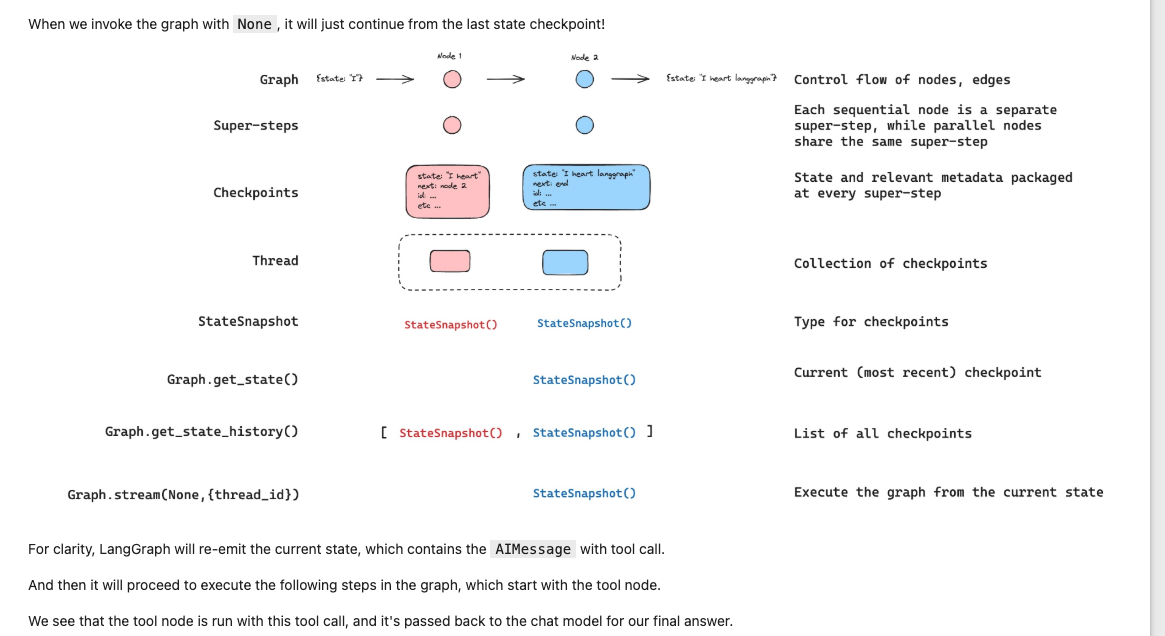

In [27]:
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================== Ai Message ==================================
Tool Calls:
  multiply (call_POOjexFJlRYPlrT8lmPSocIq)
 Call ID: call_POOjexFJlRYPlrT8lmPSocIq
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2 times 3 is 6.


In [28]:
initial_input = {"messages" : [HumanMessage(content = "What is 2 times 3?")]}

thread = {"configurable" : {"thread_id" : "9"}}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

user_approval = input("Do you want to continue? (y/n)")

if user_approval.lower() == "y":

    for event in graph.stream(None, thread, stream_mode="values"):

        event["messages"][-1].pretty_print()

else: 
    print("Operation was cancelled by user.")


================================ Human Message =================================

What is 2 times 3?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_eDAsV53LJNJYzlEBa4W3NvDA)
 Call ID: call_eDAsV53LJNJYzlEBa4W3NvDA
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_eDAsV53LJNJYzlEBa4W3NvDA)
 Call ID: call_eDAsV53LJNJYzlEBa4W3NvDA
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

2 times 3 is 6.


# Breakpoints with Langgraph API

In [29]:
from langgraph_sdk import get_client

client = get_client(url = "http://localhost:57313")


In [31]:
from pprint import pprint
assistants = await client.assistants.search()

pprint(assistants)


[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'config': {},
  'created_at': '2025-01-04T05:40:39.752321+00:00',
  'graph_id': 'dynamic_breakpoints',
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'updated_at': '2025-01-04T05:40:39.752321+00:00',
  'version': 1},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'config': {},
  'created_at': '2025-01-04T05:40:39.749151+00:00',
  'graph_id': 'agent',
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'updated_at': '2025-01-04T05:40:39.749151+00:00',
  'version': 1}]


/var/folders/3g/r3ht76p907vdqxh325xx85tm0000ks/T/ipykernel_82938/42621030.py:2: RuntimeWarning: coroutine 'AssistantsClient.search' was never awaited
  assistants = await client.assistants.search()


In [33]:
initial_input = {"messages" : [HumanMessage(content = "What is 2 times 3?")]}

thread = await client.threads.create()

async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = initial_input,
    stream_mode="values",
    interrupt_before = ["tools"],
):
    print(f"Receiving new events of type: {chunk.event}...")
    messages = chunk.data.get('messages',[])
    if messages:
        print(messages[-1])
    print("-"*100)



Receiving new events of type: metadata...
----------------------------------------------------------------------------------------------------
Receiving new events of type: values...
{'content': 'What is 2 times 3?', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'd7d92799-02e8-4d63-817a-f1f5e0443c87', 'example': False}
----------------------------------------------------------------------------------------------------
Receiving new events of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_VO4XkIvlrc07uuZVtwj88bHr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 136, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_to

In [34]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input = None,
    stream_mode="values",
    interrupt_before = ["tools"],
):
    print(f"Receiving new events of type: {chunk.event}...")
    messages = chunk.data.get('messages',[])
    if messages:
        print(messages[-1])
    print("-"*100)

Receiving new events of type: metadata...
----------------------------------------------------------------------------------------------------
Receiving new events of type: values...
{'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_VO4XkIvlrc07uuZVtwj88bHr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 18, 'prompt_tokens': 136, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d28bcae782', 'finish_reason': 'tool_calls', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run-6bec6d68-6478-4d08-b2d5-426ad76fe3b9-0', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_VO4XkIvlrc07